<a href="https://colab.research.google.com/github/elvinaqa/Intent-Recognition-Flask-Deployment/blob/main/Intent_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install BERT, Import Libs

In [ ]:
!pip install bert-for-tf2 

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data

The data: [GitHub](https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines)

In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test (1).csv
Saving valid.csv to valid (1).csv
Saving train.csv to train.csv


{'test.csv': b'text,intent\nadd sabrina salerno to the grime instrumentals playlist,AddToPlaylist\ni want to bring four people to a place that s close to downtown that serves churrascaria cuisine,BookRestaurant\nput lindsey cardinale into my hillary clinton s women s history month playlist,AddToPlaylist\nwill it snow in mt on june 13  2038,GetWeather\nplay signe anderson chant music that is newest,PlayMusic\ncan you let me know what animated movies are playing close by,SearchScreeningEvent\ncan you get me reservations for a highly rated restaurant in seychelles,BookRestaurant\nwhat s the weather here on 2/7/2021,GetWeather\nfind worldly goods starting now at a movie house,SearchScreeningEvent\non june 27  2026 i d like to go to a delaware gastropub,BookRestaurant\nwhat movies are playing at mann theatres,SearchScreeningEvent\nfind a movie called living in america,SearchCreativeWork\nfind on dress parade,SearchScreeningEvent\nmake a reservation at a bakery that has acquacotta in central

In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
train.shape

(13784, 2)

In [ ]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


# Balanced Dataset

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


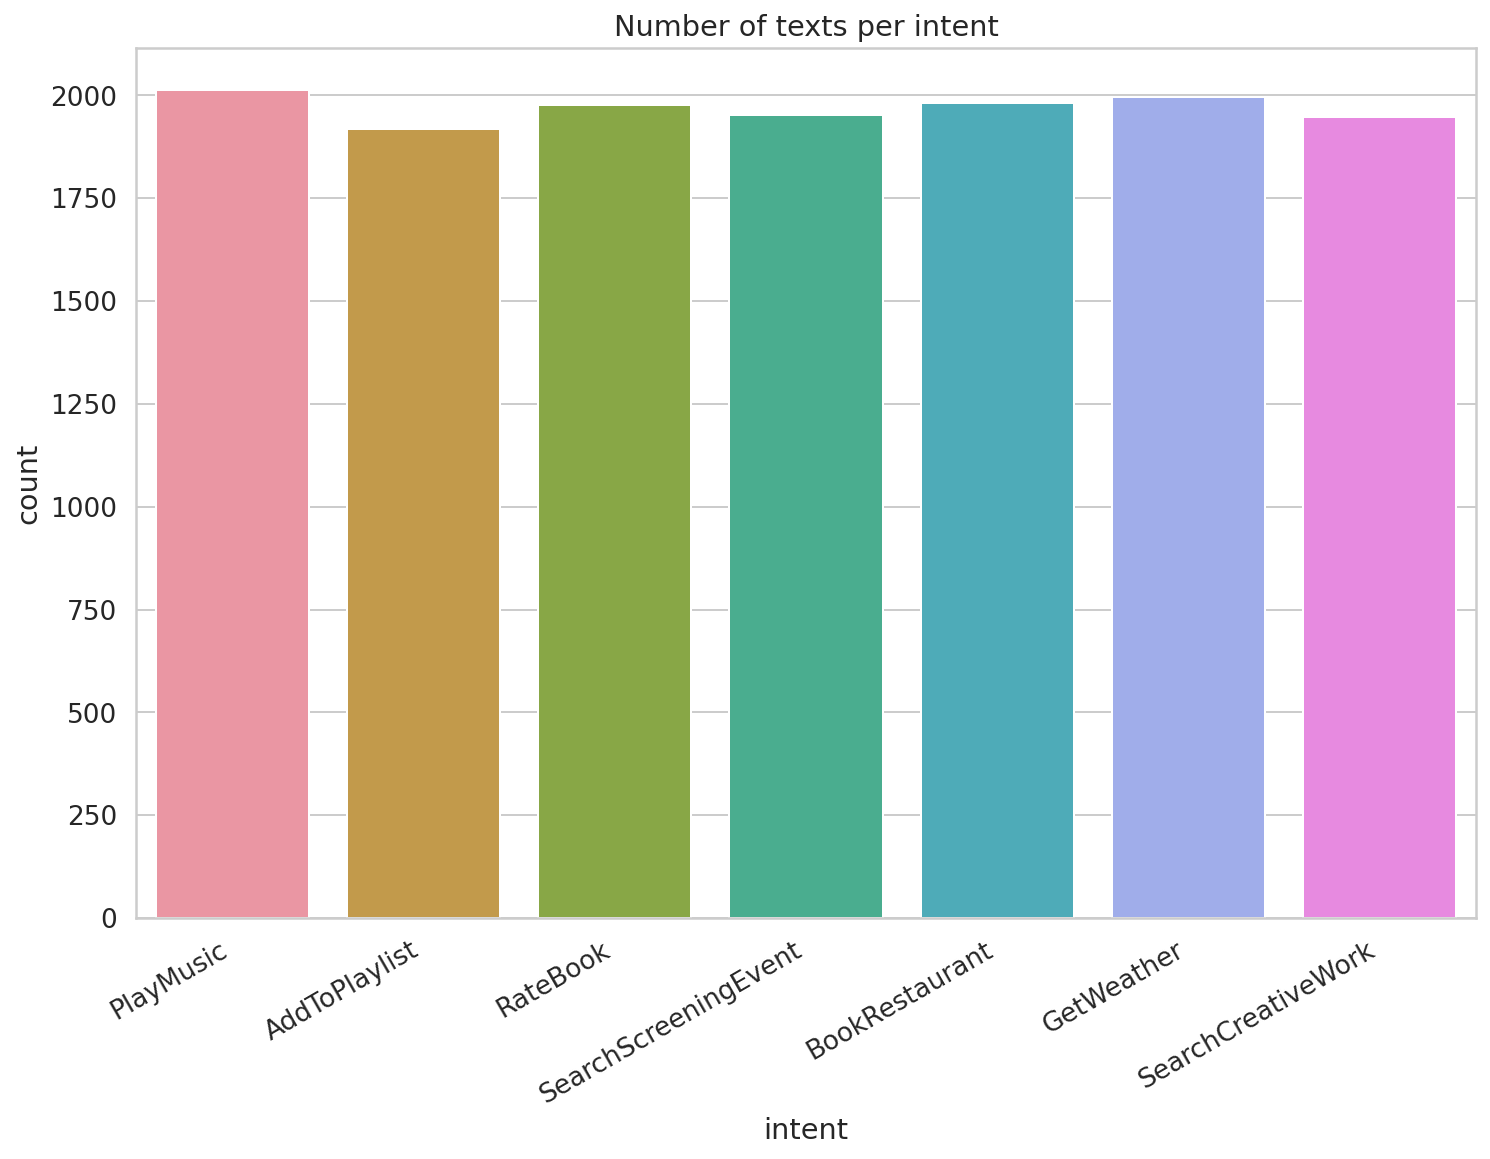

In [ ]:
chart = sns.countplot(train.intent)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Download pretrained BERT model

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-10-21 16:16:05--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 74.125.139.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   183MB/s    in 2.1s    

2020-10-21 16:16:08 (183 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Tokenization, vectorization and padding

In [ ]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

credits to [Col](https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb) for this

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
tokenizer.tokenize("Karabakh is Azerbaijan")

['kara', '##ba', '##kh', 'is', 'azerbaijan']

In [ ]:
tokens = tokenizer.tokenize("Stop Armenian Aggression")
tokenizer.convert_tokens_to_ids(tokens)

[2644, 7508, 14974]

# Load BERT Model

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [ ]:
classes = train.intent.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:04, 2923.90it/s]
700it [00:00, 2917.61it/s]


max seq_len 38


In [ ]:
data.train_x.shape

(13784, 38)

In [ ]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [ ]:
data.train_y[0]

0

In [ ]:
data.max_seq_len

38

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f8483c1bef0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

# Training BERT

BERT's recommendation for training

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
# for tensorboard
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
776/776 [==============================] - 511s 659ms/step - loss: 1.1758 - acc: 0.9902 - val_loss: 1.1785 - val_acc: 0.9869
Epoch 2/5
776/776 [==============================] - 509s 656ms/step - loss: 1.1741 - acc: 0.9915 - val_loss: 1.1765 - val_acc: 0.9891
Epoch 3/5
776/776 [==============================] - 513s 661ms/step - loss: 1.1735 - acc: 0.9921 - val_loss: 1.1763 - val_acc: 0.9891
Epoch 4/5
776/776 [==============================] - 512s 660ms/step - loss: 1.1750 - acc: 0.9903 - val_loss: 1.1751 - val_acc: 0.9906
Epoch 5/5
776/776 [==============================] - 512s 660ms/step - loss: 1.1738 - acc: 0.9916 - val_loss: 1.1768 - val_acc: 0.9884


## Evaluation

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir log

# Wow 97%

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

22/22 [==============================] - 5s 233ms/step - loss: 1.1870 - acc: 0.9786
train acc 0.9928902983665466
test acc 0.9785714149475098


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.94      0.99      0.97        86
       AddToPlaylist       0.99      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       1.00      0.93      0.96       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.93      0.95      0.94       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

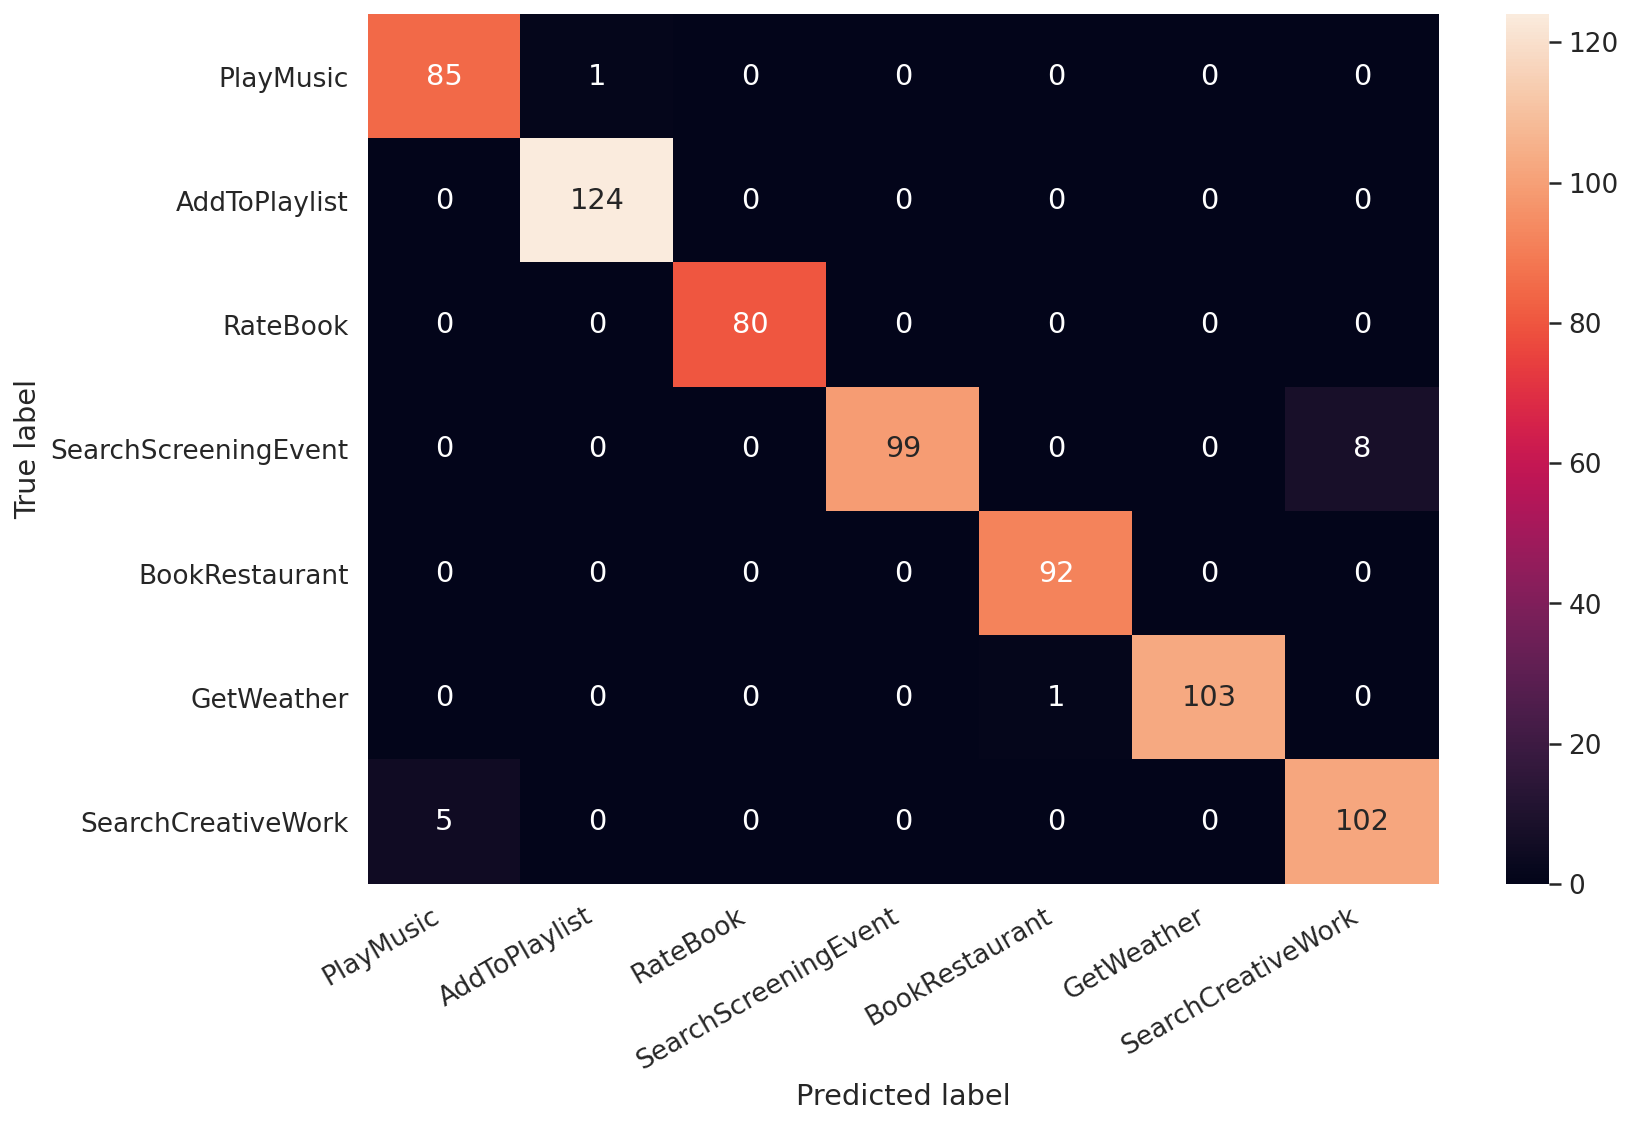

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
sentences = [
  "Play our song now",
  "Rate this book as awful"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song now 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook



# References

- http://docs.deeppavlov.ai/en/master/features/models/bert.html
- https://github.com/deepmipt/intent_classifier/blob/master/dp_ir_snips.png
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb
- https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines
- https://jalammar.github.io/illustrated-bert/
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
- https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/

<!--  
# !gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
# !gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
# !gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv-->